In [1]:
import time
import csv
from tqdm.auto import tqdm
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sn
import numpy as np

from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!git clone github_path "/content/drive/My Drive/HWs/NLP/HW1"

fatal: destination path '/content/drive/My Drive/HWs/NLP/HW1' already exists and is not an empty directory.


### Data Preparation

In [ ]:
class build_dataset():
  def __init__(self, train_set_path, valid_set_path, test_set_path, ngram:int = 0,
               sentence_limit:int = 9999999999, delete_freq= False, lemmatize= False, device="cuda"):
    # memory crash while using ngrams, use sentence_limit
 
    self.device = device
    self.delete_freq = delete_freq
    self.limit = sentence_limit
    self.lemma = lemmatize
    self.ngram = ngram
    self.max = 0
    
    self.train_set, self.train_gold = self.read_files(train_set_path, vocab=True) # vocab = True : add words to the vocabulary
    print("Read, Training data: DONE!")
    self.dev_set, self.dev_gold = self.read_files(valid_set_path)
    print("Read, Validation data: DONE!")
    self.test_set, self.test_gold = self.read_files(test_set_path) # test = True : create a dict to get labels later
    print("Read, Test data: DONE!")

    print("\n")
    self.build_vocab(self.train_set)
    print("Vocab size:", len(self.vocabulary))
    self.index_classes(self.train_gold)
    print("Class size:", len(self.indexed_classes))
    print("Classes:", self.indexed_classes)

    print("\n")
    self.indexed_train = self.index_words(self.train_set, train= True)
    print("Index, Training data: DONE!")
    self.indexed_train_gold = self.index_labels(self.train_gold)
    print("Index, Training gold data: DONE!")

    self.indexed_dev = self.index_words(self.dev_set)
    print("Index, Validation data: DONE!")
    self.indexed_dev_gold = self.index_labels(self.dev_gold)
    print("Index, Validation gold data: DONE!")

    self.indexed_test = self.index_words(self.test_set)
    print("Index, Test data: DONE!")
    self.indexed_test_gold = self.index_labels(self.test_gold)
    print("Index, Test gold data: DONE!")

    print("\n")    
    self.train_data = self.build(self.indexed_train, self.indexed_train_gold)    
    print("Build, Training dataset: DONE!")    
    self.dev_data = self.build(self.indexed_dev, self.indexed_dev_gold)    
    print("Build, Validation dataset: DONE!")    
    self.test_data = self.build(self.indexed_test, self.indexed_test_gold)
    print("Build, Test dataset: DONE!")
    
  def build(self, inputs, outputs):
    dataset = []
    for i in tqdm(range(len(inputs))):
      x = inputs[i]
      y = outputs[i]
      
      element = {"inputs": torch.LongTensor(x).to(self.device), "outputs": torch.LongTensor(y).to(self.device)}
      dataset.append(element)
    return dataset

  def index_labels(self, data): # index the gold file
    indexed_seq = []
    for seq in self.padding_opt(data, label=True):
      indexed = []
      for label in seq:
        indexed.append(self.indexed_classes[label])
      indexed_seq.append(indexed)
    return indexed_seq

  def index_classes(self, data): # determines the classes
    # Runs only once
    self.indexed_classes = {}
    self.indexed_classes["<PAD>"] = 0
    for seq in data:
      for label in seq:
        if label not in self.indexed_classes:
          self.indexed_classes[label] = len(self.indexed_classes)

  def lemmatize_words(self, word):

    if self.lemma: # if its True then try to lemmatize the word
      try:
        return lemmatizer.lemmatize(word)
      except:
        return word
    else:
      return word

  def index_words(self, data, train=False):
    indexed_sentences = []
    
    if self.ngram < 2: #unigram
      for line in data:
        x_id = []
        for word in line:
          word = self.lemmatize_words(word)
          try:
            x_id.append(self.vocabulary[word])
          except:
            x_id.append(self.vocabulary["<UNK>"])
        indexed_sentences.append(x_id)
    else:
      for line in data:

        n_id = []
        for word_id in range(len(line)):
          x_id = []
          for n in range(self.ngram):
            try:
              word = self.lemmatize_words(line[word_id + n])
            except:
              for n in range(self.ngram - 1):
                line.append(self.vocabulary["<PAD>"])
            word = self.lemmatize_words(line[word_id + n])
            
            try:
              x_id.append(self.vocabulary[word])
            except:
              x_id.append(self.vocabulary["<UNK>"])
          try:
            self.n_vocabulary[str(x_id)]
            n_id.append(self.n_vocabulary[str(x_id)])
          except:
            if train:
              self.n_vocabulary[str(x_id)] = len(self.n_vocabulary)+1 # this vocab doesn't have PAD token, so starts indexing from 1
              n_id.append(self.n_vocabulary[str(x_id)])
            else:
              n_id.append(self.n_vocabulary["<UNK>"])

        indexed_sentences.append(n_id)

      indexed_sentences = self.get_freq(indexed_sentences)
    return self.padding_opt(indexed_sentences, pad = self.vocabulary["<PAD>"])

  def get_freq(self, data):
    if self.ngram < 2:
      return data

    freq = {}
    for line in data:
      for word_id in line:        
        try:
          freq[word_id] +=1
        except:
          freq[word_id] = 1

    count = 0
    count_data = 0
    for line in range(len(data)):
      for word in range(len(data[line])):
        count_data+= 1
        if freq[data[line][word]] == 1:
          count+=1
          if self.delete_freq:
            data[line][word] = len(self.n_vocabulary)+1

    if count_data > 800000:
      print("In the training data,")
      print("Number of the bigrams with 1 frequency:", count)
      print("Number of the bigrams:", len(self.n_vocabulary))
    return data

  def padding_opt(self, data, label=False, pad = "<PAD>"):
    for line in data:
      while len(line) < self.max:
        line.append(pad)
    return data

  def build_vocab(self, data_x):
    # runs only once
    self.n_vocabulary = {}
    self.n_vocabulary["<UNK>"] = 1
    for  line in data_x:
      for word in line:
        word = self.lemmatize_words(word)

        try:
          self.vocabulary
        except:
          self.vocabulary = {}
          self.vocabulary["<PAD>"] = 0
          self.vocabulary["<UNK>"] = 1

        try:
          self.vocabulary[word]
        except:
          self.vocabulary[word] = len(self.vocabulary)

  def read_files(self, path, vocab=False):
    self.non_vocab = {}
    self.indexed_labels = {}
    self.indexed_vocab = {}

    with open(path, newline='', encoding="utf-8") as csvfile:      
      lines = csv.reader(csvfile, delimiter=' ', quotechar='|')
      sentences = []
      gold_sentences = []
      sentence = []
      gold_sentence = []
      for line in lines:
        if self.ngram != 0: # when using ngrams, sets the test and dev set's size = train size / 5
          if not vocab:
            limit = int(self.limit / 5)
            if limit <= len(sentences):
              return sentences, gold_sentences

          if self.limit <= len(sentences):
            return sentences, gold_sentences
          
        if line: # to avoid processing empty lines
          if line[0] != "#": 
            # lines starting with integers are the ones with word and the corresponding label
            # and this is all we need
            splitted_word = line[0].split("\t")
            word = splitted_word[1]
            label = splitted_word[2]

            sentence.append(word)
            gold_sentence.append(label)

          elif sentence:
            if len(sentence) > self.max: # get max sentence length to using it in padding_opt
              self.max = len(sentence) + self.ngram
            sentences.append(sentence)
            gold_sentences.append(gold_sentence)
            
            sentence = []
            gold_sentence = []

    return sentences, gold_sentences

In [5]:
training_file = "/content/drive/My Drive/HWs/NLP/HW1/data/train.tsv"
dev_file = "/content/drive/My Drive/HWs/NLP/HW1/data/dev.tsv"
test_file = "/content/drive/My Drive/HWs/NLP/HW1/data/test.tsv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datasets = build_dataset(train_set_path= training_file, valid_set_path= dev_file, test_set_path= test_file, device= device)

training_dataset = datasets.train_data
validation_dataset = datasets.dev_data
test_dataset = datasets.test_data

print("Example data:\n", training_dataset[0])

train_dataset = DataLoader(training_dataset, batch_size=128)
valid_dataset = DataLoader(validation_dataset, batch_size=128)
testing_dataset = DataLoader(test_dataset, batch_size=128)

Read, Training data: DONE!
Read, Validation data: DONE!
Read, Test data: DONE!


Vocab size: 100842
Class size: 5
Classes: {'<PAD>': 0, 'PER': 1, 'O': 2, 'ORG': 3, 'LOC': 4}


Index, Training data: DONE!
Index, Training gold data: DONE!
Index, Validation data: DONE!
Index, Validation gold data: DONE!
Index, Test data: DONE!
Index, Test gold data: DONE!





Build, Training dataset: DONE!



Build, Validation dataset: DONE!



Build, Test dataset: DONE!
Example data:
 {'inputs': tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0'), 'outputs': tensor([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Model Building

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self, vocab_length=len(datasets.vocabulary), embedding= None, num= 2):
        super(SimpleModel, self).__init__()
        self.word_embedding = nn.Embedding(vocab_length, 100, padding_idx= datasets.indexed_classes['<PAD>']) # vocab size, embedding dimension size
        if embedding:
          self.word_embedding.weight.data.copy_(torch.stack(embedding))

        self.lstm = nn.LSTM(100, # embedding dimension
                            100, # hidden dimension
                            bidirectional=True, 
                            num_layers=num, # number of lstm layer
                            dropout = 0.5, 
                            batch_first=True)
        
        lstm_output_dim = 200 # "hidden dimension x 2" for bidirectional
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(lstm_output_dim, len(datasets.indexed_classes)) # lstm output dimension, number of the labels in the dataset

    def forward(self, x):
        embeddings = self.word_embedding(x)
        embeddings = self.dropout(embeddings)
        o, (h, c) = self.lstm(embeddings)
        o = self.dropout(o)
        output = self.classifier(o)
        return output

In [ ]:
class Trainer():
  def __init__(self, model: nn.Module, loss_function, optimizer, 
               label_vocab: datasets.vocabulary):
    
    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer

    self.label_vocab = label_vocab
        
  def train(self, train_dataset, 
            valid_dataset, 
            epochs:int=1):

    assert epochs > 0 and isinstance(epochs, int)

    train_loss = 0.0

    for epoch in range(epochs):
      
      epoch_loss = 0.0
      self.model.train()
      print("Epoch:", epoch+1, "/", epochs)
      for step, data in enumerate(tqdm(train_dataset)):    
        self.optimizer.zero_grad()

        inputs = data['inputs']
        labels = data['outputs']

        preds = self.model(inputs)
        preds = preds.view(-1, preds.shape[-1])
        labels = labels.view(-1)
        
        sample_loss = self.loss_function(preds, labels)
        sample_loss.backward()
        self.optimizer.step()

        epoch_loss += sample_loss.tolist()

      avg_epoch_loss = epoch_loss / len(train_dataset)
      train_loss += avg_epoch_loss
      valid_loss = self.evaluate(valid_dataset)

      print("Train loss = {:0.4f}, Valid loss = {:0.4f}\n".format(avg_epoch_loss, valid_loss))

      name = get_f1(simple, test= testing_dataset)
      # path = "drive/My Drive/"
      print("f1:", name)
      # if name > 0.92:
      #   name = str(name) + "_" + str(epoch+1)
      #   torch.save(simple.state_dict(), path + name)
      loss_x.append(avg_epoch_loss)
      loss_y.append(valid_loss)

    avg_epoch_loss = train_loss / epochs
     
    
    return avg_epoch_loss


  def evaluate(self, valid_dataset):

    valid_loss = 0.0
    self.model.eval()
    with torch.no_grad():
      for data in valid_dataset:
        inputs = data['inputs']
        labels = data['outputs']

        preds = self.model(inputs)
        preds = preds.view(-1, preds.shape[-1])
        labels = labels.view(-1)
        sample_loss = self.loss_function(preds, labels)
        valid_loss += sample_loss.tolist()
    
    return valid_loss / len(valid_dataset)

  def predict(self, x):

    self.model.eval()
    with torch.no_grad():
      logs = self.model(x)
      preds = torch.argmax(logs, -1)
      return logs, preds

In [ ]:
def get_f1(model:nn.Module, test:DataLoader, get_preds= False):
    predictions = list()
    labels = list()
    for data in test:
        x = data["inputs"]
        pred = model(x)
        pred = torch.argmax(pred, -1).view(-1)

        y = data["outputs"]
        label = y.view(-1)
        valid_indices = label != 0
        
        valid_predictions = pred[valid_indices]
        valid_labels = label[valid_indices]
        
        predictions.extend(valid_predictions.tolist())
        labels.extend(valid_labels.tolist())
    
    if get_preds:
      return predictions, labels
    
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)
    
    return f1_macro

Simple Bi-LSTM Model

Epoch: 1 / 3



Train loss = 0.2468, Valid loss = 0.1251

f1: 0.7915874596766599
Epoch: 2 / 3



Train loss = 0.1338, Valid loss = 0.0920

f1: 0.8561942025871534
Epoch: 3 / 3



Train loss = 0.1022, Valid loss = 0.0812

f1: 0.8741985161539003
[[ 13981   1112    369    292]
 [   960 332232   1403   1269]
 [   244   1242   7211    654]
 [   162    970    662  11259]]


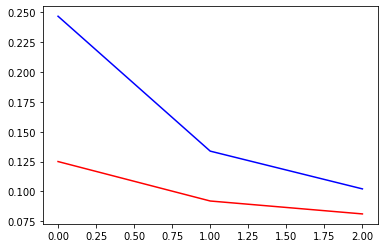

In [9]:
simple = SimpleModel().cuda()
simple_trainer = Trainer( 
  model = simple,
  loss_function = nn.CrossEntropyLoss(ignore_index=datasets.indexed_classes['<PAD>']),
  optimizer = optim.Adam(simple.parameters(), lr=0.003),
  label_vocab=datasets.vocabulary
)
loss_x = []
loss_y = []
simple_trainer.train(train_dataset, valid_dataset, 3)
plt.plot(loss_x, "-b", loss_y , "-r")
pred_y, gold_y = get_f1(simple, testing_dataset, get_preds= True)
data = confusion_matrix(pred_y, gold_y)
print(data)

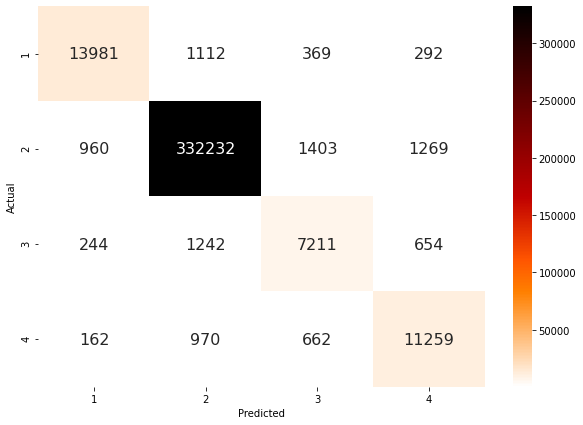

In [10]:
cm_hm = pd.DataFrame(data, columns=np.unique(gold_y), index = np.unique(gold_y))
cm_hm.index.name = 'Actual'
cm_hm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))

sn.heatmap(cm_hm, cmap="gist_heat_r", annot=True, annot_kws={"size": 16}, fmt="d")

Training model with using GLoVe Pre-trained embeddings

In [ ]:
embeddings = {}
path = "drive/My Drive/HWs/"
name = "glove.6B.100d.txt"
with open(path + name, 'r') as f:
  for line in f:
    values = line.split()
    word = values[0] # first element is the word
    vector = np.asarray(values[1:], "float32") # rest is vector elements
    embeddings[word] = vector

In [ ]:
pre_trained_emb = []
count = 0
for word in datasets.vocabulary:
  count += 1
  try:
    x = embeddings[word]
  except:
    x = np.random.rand(100)
    
  pre_trained_emb.append(torch.LongTensor(x))


Epoch: 1 / 3



Train loss = 0.1919, Valid loss = 0.0855

f1: 0.862545198942098
Epoch: 2 / 3



Train loss = 0.0700, Valid loss = 0.0676

f1: 0.9028381604445079
Epoch: 3 / 3



Train loss = 0.0491, Valid loss = 0.0628

f1: 0.9125710237786177
[[ 14223    468    121    105]
 [   833 333666   1295   1051]
 [   168    722   7730    431]
 [   123    700    499  11887]]


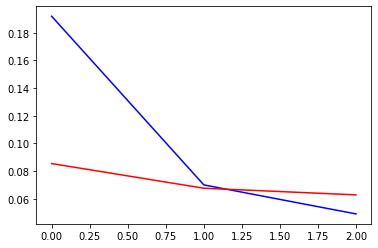

In [13]:
simple = SimpleModel(embedding= pre_trained_emb).cuda()
simple_trainer = Trainer( 
  model = simple,
  loss_function = nn.CrossEntropyLoss(ignore_index=datasets.indexed_classes['<PAD>']),
  optimizer = optim.Adam(simple.parameters(), lr=0.001),
  label_vocab=datasets.vocabulary
)
loss_x = []
loss_y = []
simple_trainer.train(train_dataset, valid_dataset, 3)
plt.plot(loss_x, "-b", loss_y , "-r")
pred_y, gold_y = get_f1(simple, testing_dataset, get_preds= True)
data = confusion_matrix(pred_y, gold_y)
print(data)

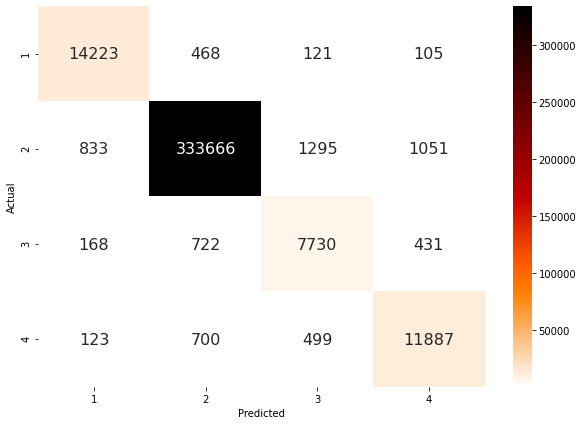

In [14]:
cm_hm = pd.DataFrame(data, columns=np.unique(gold_y), index = np.unique(gold_y))
cm_hm.index.name = 'Actual'
cm_hm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))

sn.heatmap(cm_hm, cmap="gist_heat_r", annot=True, annot_kws={"size": 16}, fmt="d")

Training model with lemmatized inputs

In [15]:
datasets = build_dataset(train_set_path= training_file, valid_set_path= dev_file, test_set_path= test_file, lemmatize= True, device= device)

training_dataset = datasets.train_data
validation_dataset = datasets.dev_data
test_dataset = datasets.test_data

print("Example data:\n", training_dataset[0])

train_dataset = DataLoader(training_dataset, batch_size=128)
valid_dataset = DataLoader(validation_dataset, batch_size=128)
testing_dataset = DataLoader(test_dataset, batch_size=128)

Read, Training data: DONE!
Read, Validation data: DONE!
Read, Test data: DONE!


Vocab size: 94943
Class size: 5
Classes: {'<PAD>': 0, 'PER': 1, 'O': 2, 'ORG': 3, 'LOC': 4}


Index, Training data: DONE!
Index, Training gold data: DONE!
Index, Validation data: DONE!
Index, Validation gold data: DONE!
Index, Test data: DONE!
Index, Test gold data: DONE!





Build, Training dataset: DONE!



Build, Validation dataset: DONE!



Build, Test dataset: DONE!
Example data:
 {'inputs': tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0'), 'outputs': tensor([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Epoch: 1 / 3



Train loss = 0.2435, Valid loss = 0.1244

f1: 0.7957668535535981
Epoch: 2 / 3



Train loss = 0.1312, Valid loss = 0.0925

f1: 0.8551696719735753
Epoch: 3 / 3



Train loss = 0.1007, Valid loss = 0.0818

f1: 0.8783874027375204
[[ 13559    729    260    211]
 [  1368 332904   1583   1343]
 [   229    970   7143    561]
 [   191    953    659  11359]]


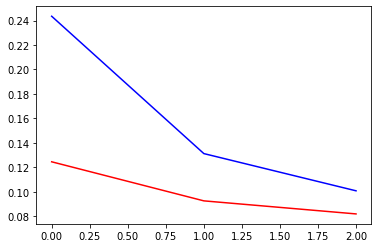

In [16]:
simple = SimpleModel().cuda()
simple_trainer = Trainer( 
  model = simple,
  loss_function = nn.CrossEntropyLoss(ignore_index=datasets.indexed_classes['<PAD>']),
  optimizer = optim.Adam(simple.parameters(), lr=0.003),
  label_vocab=datasets.vocabulary
)
loss_x = []
loss_y = []
simple_trainer.train(train_dataset, valid_dataset, 3)
plt.plot(loss_x, "-b", loss_y , "-r")
pred_y, gold_y = get_f1(simple, testing_dataset, get_preds= True)
data = confusion_matrix(pred_y, gold_y)
print(data)

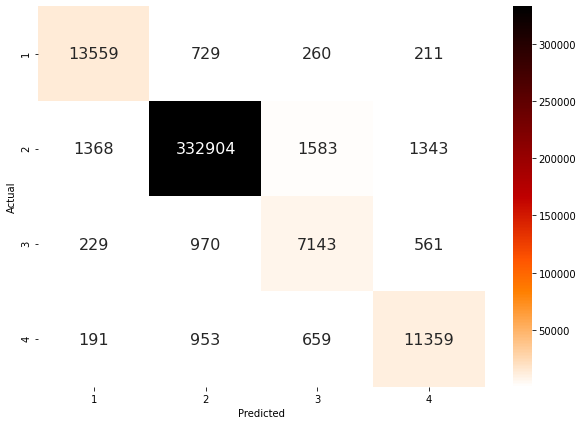

In [17]:
cm_hm = pd.DataFrame(data, columns=np.unique(gold_y), index = np.unique(gold_y))
cm_hm.index.name = 'Actual'
cm_hm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))

sn.heatmap(cm_hm, cmap="gist_heat_r", annot=True, annot_kws={"size": 16}, fmt="d")

Training model with using bigrams input

In [18]:
datasets = build_dataset(train_set_path= training_file, valid_set_path= dev_file, test_set_path= test_file, ngram= 2,device= device)

training_dataset = datasets.train_data
validation_dataset = datasets.dev_data
test_dataset = datasets.test_data
train_dataset = DataLoader(training_dataset, batch_size=128)
valid_dataset = DataLoader(validation_dataset, batch_size=128)
testing_dataset = DataLoader(test_dataset, batch_size=128)

Read, Training data: DONE!
Read, Validation data: DONE!
Read, Test data: DONE!


Vocab size: 100842
Class size: 5
Classes: {'<PAD>': 0, 'PER': 1, 'O': 2, 'ORG': 3, 'LOC': 4}


In the training data,
Number of the bigrams with 1 frequency: 626887
Number of the bigrams: 847869
Index, Training data: DONE!
Index, Training gold data: DONE!
Index, Validation data: DONE!
Index, Validation gold data: DONE!
Index, Test data: DONE!
Index, Test gold data: DONE!





Build, Training dataset: DONE!



Build, Validation dataset: DONE!



Build, Test dataset: DONE!


In [19]:
count = 0 
for key in datasets.n_vocabulary:
  print(key,":", datasets.n_vocabulary[key])
  count += 1
  if count > 10:
    break

<UNK> : 1
[2, 3] : 2
[3, 4] : 3
[4, 5] : 4
[5, 6] : 5
[6, 7] : 6
[7, 8] : 7
[8, 9] : 8
[9, 10] : 9
[10, 11] : 10
[11, 12] : 11


Epoch: 1 / 3



Train loss = 0.4313, Valid loss = 0.3718

f1: 0.2978712242098222
Epoch: 2 / 3



Train loss = 0.3585, Valid loss = 0.3214

f1: 0.39297876909618884
Epoch: 3 / 3



Train loss = 0.3147, Valid loss = 0.2808

f1: 0.45821401776516946
[[   690    185     66     66]
 [ 14495 333769   6603   8610]
 [    33    450   2177    305]
 [   129   1152    799   4493]]


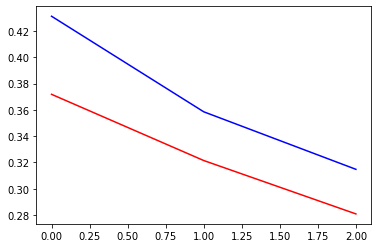

In [20]:
n = len(datasets.n_vocabulary)
simple = SimpleModel(vocab_length= n, num= 2).cuda()
simple_trainer = Trainer( 
  model = simple,
  loss_function = nn.CrossEntropyLoss(ignore_index=datasets.indexed_classes['<PAD>']),
  optimizer = optim.Adam(simple.parameters(), lr=0.001),
  label_vocab=datasets.vocabulary
)
loss_x = []
loss_y = []
simple_trainer.train(train_dataset, valid_dataset, 3)
plt.plot(loss_x, "-b", loss_y , "-r")
pred_y, gold_y = get_f1(simple, testing_dataset, get_preds= True)
data = confusion_matrix(pred_y, gold_y)
print(data)

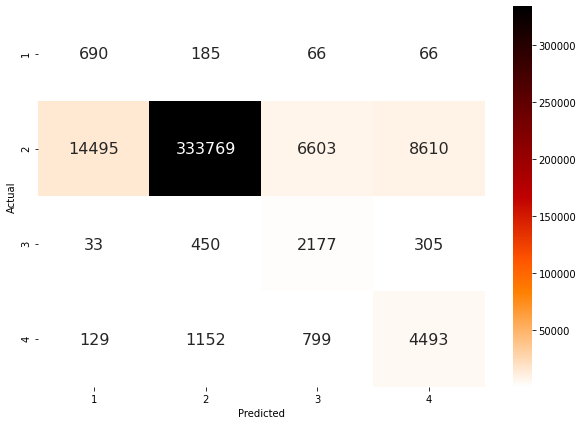

In [21]:
cm_hm = pd.DataFrame(data, columns=np.unique(gold_y), index = np.unique(gold_y))
cm_hm.index.name = 'Actual'
cm_hm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))

sn.heatmap(cm_hm, cmap="gist_heat_r", annot=True, annot_kws={"size": 16}, fmt="d")

In [22]:
datasets = build_dataset(train_set_path= training_file, valid_set_path= dev_file, test_set_path= test_file, device= device)

training_dataset = datasets.train_data
validation_dataset = datasets.dev_data
test_dataset = datasets.test_data

print("Example data:\n", training_dataset[0])

train_dataset = DataLoader(training_dataset, batch_size=128)
valid_dataset = DataLoader(validation_dataset, batch_size=128)
testing_dataset = DataLoader(test_dataset, batch_size=128)

Read, Training data: DONE!
Read, Validation data: DONE!
Read, Test data: DONE!


Vocab size: 100842
Class size: 5
Classes: {'<PAD>': 0, 'PER': 1, 'O': 2, 'ORG': 3, 'LOC': 4}


Index, Training data: DONE!
Index, Training gold data: DONE!
Index, Validation data: DONE!
Index, Validation gold data: DONE!
Index, Test data: DONE!
Index, Test gold data: DONE!





Build, Training dataset: DONE!



Build, Validation dataset: DONE!



Build, Test dataset: DONE!
Example data:
 {'inputs': tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0'), 'outputs': tensor([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
path = "drive/My Drive/epoch_24_dr_0.5_0.9232418840908364"
model = SimpleModel().cuda()
model.load_state_dict(torch.load(path))
model.eval()
f1 = get_f1(model, testing_dataset)
print(model)
print("The model I used, f1:", f1)

SimpleModel(
  (word_embedding): Embedding(100842, 100, padding_idx=0)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=200, out_features=5, bias=True)
)
The model I used, f1: 0.9232418840908364


In [24]:
pred_y, gold_y = get_f1(model, testing_dataset, get_preds= True)
data = confusion_matrix(pred_y, gold_y)
data

array([[ 14680,    701,    163,    121],
       [   458, 333255,    947,    772],
       [    98,    882,   8099,    389],
       [   111,    718,    436,  12192]])

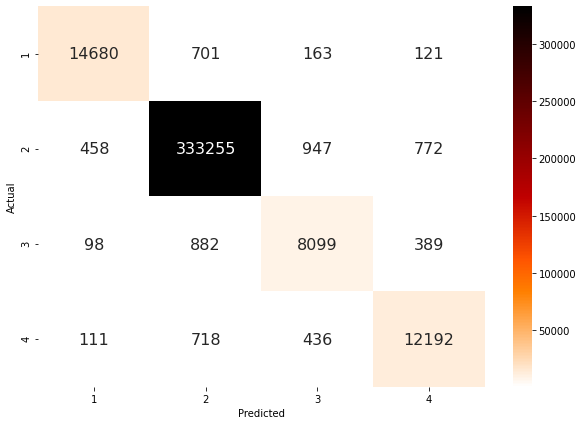

In [25]:
cm_hm = pd.DataFrame(data, columns=np.unique(gold_y), index = np.unique(gold_y))
cm_hm.index.name = 'Actual'
cm_hm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))

sn.heatmap(cm_hm, cmap="gist_heat_r", annot=True, annot_kws={"size": 16}, fmt="d")

In [26]:
def encode(data, vocab):
  length_sentences = []
  encoded_sentences = []
  for sentence in data:    
    encoded_words = []
    for word in sentence:
      try:
        element = vocab[word]
      except:
        element = vocab["<UNK>"]
      encoded_words.append(element)
    length_sentences.append(len(sentence))
    while len(encoded_words) < 200:
      encoded_words.append(vocab["<PAD>"])
    encoded_sentences.append(torch.LongTensor(encoded_words).to(device))
  return torch.stack(encoded_sentences), length_sentences

def decode(data, labels, length):
  decoded_sequences = []
  for seq_index in range(len(data)):
    decoded_labels = []
    for word_lengths in range(length[seq_index]):
      sequence = data[seq_index]
      label_id = sequence[word_lengths]
      for key in labels.keys():
        if label_id == labels[key]:
          decoded_labels.append(key)
    decoded_sequences.append(decoded_labels)
  return decoded_sequences


a = [["John", "went", "to", "California", "to", "visit", "Google"]]

encoded_a, lengths = encode(a, datasets.vocabulary)
logits = model(encoded_a)
predictions = torch.argmax(logits, -1)

pred = decode(predictions, datasets.indexed_classes, lengths)
for x_id in range(len(pred[0])):
  print(a[0][x_id],":", pred[0][x_id])

John : PER
went : O
to : O
California : LOC
to : O
visit : O
Google : ORG
